# Import Library

In [199]:
# load data
import glob
import os

# computing
import numpy as np
import pandas as pd

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# feature extraction
import cv2
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer # https://realpython.com/k-means-clustering-python/
from sklearn.decomposition import PCA

# modelling
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

# evalutaion
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

# load/save model
import pickle

# Load Data

- input: -
- output: `X, y`

In [200]:
# ukurang gambar 224x224
def import_image(file) :
    image = cv2.imread(file)
    image = cv2.bitwise_not(image)
    return image

def label_image(character, length) :
    array = np.full(length, character)
    return array

def import_data(character, path) :
    file_path = glob.glob(path)
    images = np.array([import_image(file) for file in file_path])
    label = label_image(character, len(file_path))
    
    return images, label

In [201]:
hanacaraka = ('ba','ca','da','dha','ga','ha','ja','ka','la','ma','na','nga','nya','pa','ra','sa','ta','tha','wa','ya')

raw_X = np.empty((0, 224, 224, 3), np.uint8)
raw_y = np.empty((0))

for character in hanacaraka:
    dataset_path = "../Dataset/campuran/" + character + "/*.png"
    
    temp_X, temp_y = import_data(character, dataset_path)
    
    print("Ukuran karakter", character, ":", temp_X.shape[0])
    
    raw_X = np.append(raw_X, temp_X, axis=0)
    raw_y = np.append(raw_y, temp_y, axis=0)


Ukuran karakter ba : 21
Ukuran karakter ca : 21
Ukuran karakter da : 21
Ukuran karakter dha : 21
Ukuran karakter ga : 21
Ukuran karakter ha : 21
Ukuran karakter ja : 21
Ukuran karakter ka : 21
Ukuran karakter la : 21
Ukuran karakter ma : 21
Ukuran karakter na : 21
Ukuran karakter nga : 21
Ukuran karakter nya : 21
Ukuran karakter pa : 21
Ukuran karakter ra : 21
Ukuran karakter sa : 21
Ukuran karakter ta : 21
Ukuran karakter tha : 21
Ukuran karakter wa : 21
Ukuran karakter ya : 21


In [202]:
# Ukuran keseluruhan data
print("Jumlah data:", raw_X.shape[0])
print("Dimensi gambar:", raw_X[0].shape)

Jumlah data: 420
Dimensi gambar: (224, 224, 3)


# Augmantation & Preparation Data
List Augmented :
1. Rotate 30 CCW
2. Rotate 15 CCW + Zoom out
3. Rotate 15 CW + Zoom out
4. Rotate 30 CW
5. Shear Left
6. Shear Right
7. Normal

In [204]:
# Augmented Method
def rotate(img, degree):
    (h, w) = img.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D((cX, cY), degree, 1.0)
    img_rotated = cv2.warpAffine(img, M, (w, h))
    return img_rotated

def zoom_out(img, zoom_scale):
    img_zoom = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)

    h, w = img.shape[0]/zoom_scale, img.shape[1]/zoom_scale
    h, w = int(h), int(w)
    x, y = (img.shape[0]-w)//2, (img.shape[1]-h)//2
    img_resize = cv2.resize(img, (h, w), interpolation = cv2.INTER_AREA)

    img_zoom[x:w+x, y:h+y] = img_resize
    return img_zoom

def shear(img, x, y):
    rows, cols = img.shape
    M = np.float32([[1, x, 0],
                    [y, 1, 0]])
    sheared_img = cv2.warpAffine(img, M, (cols, rows))
    return sheared_img

# Preprocessing Image
def equalizing(img):
    if (img.ndim == 3):
        b, g, r = cv2.split(img)
        red = cv2.equalizeHist(r)
        green = cv2.equalizeHist(g)
        blue = cv2.equalizeHist(b)
        img = cv2.merge((blue, green, red))
    else:
        img = cv2.equalizeHist(img)
    return img

def grayscaling(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    return image
    
def thresholding(image, th):
    ret, image = cv2.threshold(image, th, 255, cv2.THRESH_BINARY)
    return image

def resizing(image, size):
    image = cv2.resize(image, (size, size), interpolation = cv2.INTER_AREA)
    return image

In [308]:
def dataset_aug_generator_prep(ori_img):
    ori_img = resizing(ori_img, 128)
    ori_img = grayscaling(ori_img)
#     ori_img = thresholding(ori_img, 32)
    
    ori_img = zoom_out(ori_img, 1.15)
    img_r_30_ccw = rotate(ori_img, 30)
    img_r_30_cw = rotate(ori_img, -30)
    img_r_15_ccw_z = rotate(zoom_out(ori_img, 1.3), 15)
    img_r_15_cw_z = rotate(zoom_out(ori_img, 1.3), -15)
    img_s_left = shear(ori_img, -0.15, -0.15)
    img_s_right = shear(ori_img, 0.15, 0.15)
    
    result_aug = [ori_img, img_r_30_ccw, img_r_30_cw, img_r_15_ccw_z, img_r_15_cw_z, img_s_left, img_s_right]
    for idx, item_img in enumerate(result_aug):
        result_aug[idx] = equalizing(result_aug[idx])
#         result_aug[idx] = thresholding(result_aug[idx], 32)
    return result_aug

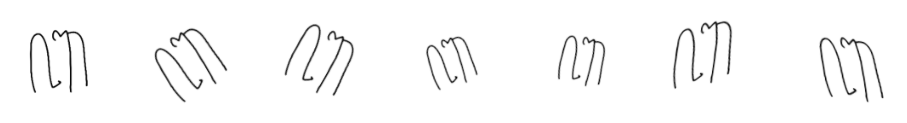

In [301]:
test_img_aug = dataset_aug_generator_prep(raw_X[0])

fig = plt.figure(figsize=(16, 4))
columns = 7
rows = 1
for i in range(1, columns*rows + 1):
    img = test_img_aug[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

In [302]:
X = np.empty((0, 128, 128), np.uint8)
y = np.empty((0))

for idx, img in enumerate(raw_X):
    img_aug = dataset_aug_generator_prep(img)
    
    for item_img in img_aug:
        X = np.append(X, [item_img], axis=0)
        y = np.append(y, [raw_y[idx]], axis=0)

In [303]:
X.shape

(2940, 128, 128)

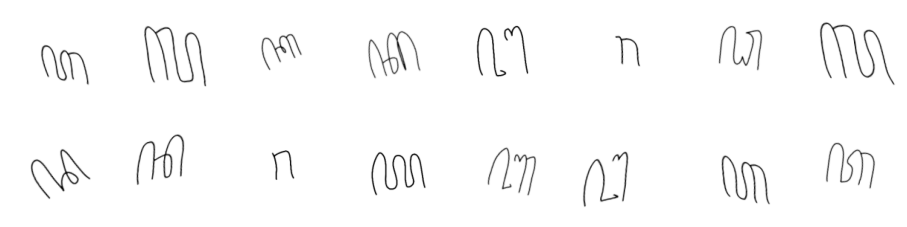

In [304]:
np.random.seed(42)

fig = plt.figure(figsize=(16, 4))
columns = 8
rows = 2
for i in range(1, columns*rows + 1):
    img = np.array(X[np.random.randint(0, X.shape[0]), :])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Feature Extraction

- input: `X`
- output: `X_feature`

### Extract sift descriptors 

In [305]:
def extract_sift_features(list_image):

    image_descriptors = []
    sift = cv2.SIFT_create()
    for image in list_image:
        _, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)

    return image_descriptors

def split_all_descriptors(image_descriptors):
    all_descriptors = []
    for descriptor in image_descriptors:
        if descriptor is not None:
            for des in descriptor:
                all_descriptors.append(des)
    
    return np.array(all_descriptors)

In [306]:
image_descriptors = extract_sift_features(X)
all_descriptors = split_all_descriptors(image_descriptors)

In [307]:
all_descriptors.shape

(90771, 128)

### Create bow of descriptor using cluster

In [15]:
# ks = [80, 100, 120, 150, 180]
# sse = []
# silhouette_coefficients = []

# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(all_descriptors)     
#     sse.append(kmeans.inertia_)
#     score = silhouette_score(all_descriptors, kmeans.labels_)
#     silhouette_coefficients.append(score)
#     print("Nilai k =", k, "(done)")

Nilai k = 100 (done)
Nilai k = 130 (done)
Nilai k = 160 (done)
Nilai k = 200 (done)
Nilai k = 240 (done)


Text(0, 0.5, 'Silhouette Coefficient')

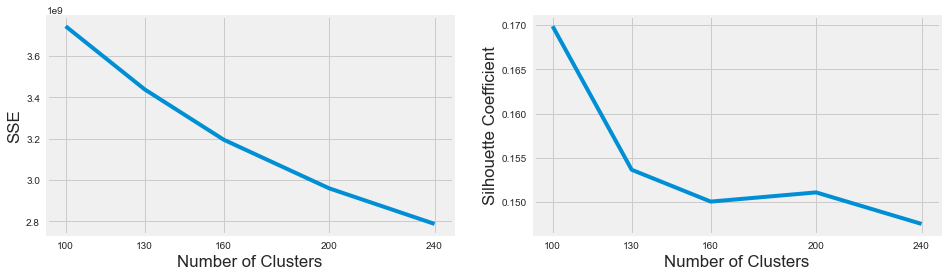

In [16]:
# fig = plt.figure(figsize=(16, 4))
# plt.style.use("fivethirtyeight")

# fig.add_subplot(1, 2, 1)
# plt.plot(ks, sse)
# plt.xticks(ks)
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")

# fig.add_subplot(1, 2, 2)
# plt.plot(ks, silhouette_coefficients)
# plt.xticks(ks)
# plt.xlabel("Number of Clusters")
# plt.ylabel("Silhouette Coefficient")

In [282]:
def kmeans_bow(all_descriptors, num_cluster):
    kmeans = KMeans(n_clusters = num_cluster, verbose=1)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    #if not os.path.isfile('bow_dictionary.pkl'):
    pickle.dump(bow_dict, open('bow_dictionary.pkl', 'wb'))

    return kmeans, bow_dict

In [283]:
num_cluster = 200
kmeans, bow = kmeans_bow(all_descriptors, num_cluster)

Initialization complete
Iteration 0, inertia 6833009664.0
Iteration 1, inertia 5102731776.0
Iteration 2, inertia 4997959680.0
Iteration 3, inertia 4954445312.0
Iteration 4, inertia 4928834560.0
Iteration 5, inertia 4910775808.0
Iteration 6, inertia 4896821760.0
Iteration 7, inertia 4885633024.0
Iteration 8, inertia 4876295168.0
Iteration 9, inertia 4868611584.0
Iteration 10, inertia 4862311936.0
Iteration 11, inertia 4857129984.0
Iteration 12, inertia 4852925440.0
Iteration 13, inertia 4849100800.0
Iteration 14, inertia 4845734400.0
Iteration 15, inertia 4842920448.0
Iteration 16, inertia 4840368128.0
Iteration 17, inertia 4838147584.0
Iteration 18, inertia 4835939328.0
Iteration 19, inertia 4833567744.0
Iteration 20, inertia 4830889472.0
Iteration 21, inertia 4828775936.0
Iteration 22, inertia 4827138048.0
Iteration 23, inertia 4825638912.0
Iteration 24, inertia 4824484352.0
Iteration 25, inertia 4823556096.0
Iteration 26, inertia 4822706176.0
Iteration 27, inertia 4821875200.0
Iterat

Iteration 230, inertia 4806579712.0
Iteration 231, inertia 4806569472.0
Iteration 232, inertia 4806560768.0
Iteration 233, inertia 4806554624.0
Iteration 234, inertia 4806549504.0
Iteration 235, inertia 4806541312.0
Iteration 236, inertia 4806532096.0
Iteration 237, inertia 4806527488.0
Iteration 238, inertia 4806517760.0
Iteration 239, inertia 4806508544.0
Iteration 240, inertia 4806498304.0
Iteration 241, inertia 4806493696.0
Iteration 242, inertia 4806490624.0
Iteration 243, inertia 4806485504.0
Iteration 244, inertia 4806479872.0
Iteration 245, inertia 4806477312.0
Iteration 246, inertia 4806475776.0
Iteration 247, inertia 4806473216.0
Iteration 248, inertia 4806471168.0
Iteration 249, inertia 4806467072.0
Iteration 250, inertia 4806466560.0
Iteration 251, inertia 4806466048.0
Iteration 252, inertia 4806463488.0
Iteration 253, inertia 4806462464.0
Iteration 254, inertia 4806458880.0
Iteration 255, inertia 4806455808.0
Iteration 256, inertia 4806456320.0
Iteration 257, inertia 48064

Iteration 29, inertia 4797505536.0
Iteration 30, inertia 4797151744.0
Iteration 31, inertia 4796812288.0
Iteration 32, inertia 4796531712.0
Iteration 33, inertia 4796253184.0
Iteration 34, inertia 4795971072.0
Iteration 35, inertia 4795697152.0
Iteration 36, inertia 4795434496.0
Iteration 37, inertia 4795145728.0
Iteration 38, inertia 4794783232.0
Iteration 39, inertia 4794392576.0
Iteration 40, inertia 4794030080.0
Iteration 41, inertia 4793635840.0
Iteration 42, inertia 4793232896.0
Iteration 43, inertia 4792755712.0
Iteration 44, inertia 4792227840.0
Iteration 45, inertia 4791666176.0
Iteration 46, inertia 4791118336.0
Iteration 47, inertia 4790582272.0
Iteration 48, inertia 4790036480.0
Iteration 49, inertia 4789421568.0
Iteration 50, inertia 4788794368.0
Iteration 51, inertia 4788188672.0
Iteration 52, inertia 4787693568.0
Iteration 53, inertia 4787305472.0
Iteration 54, inertia 4787005952.0
Iteration 55, inertia 4786764800.0
Iteration 56, inertia 4786555904.0
Iteration 57, inerti

Iteration 41, inertia 4776806912.0
Iteration 42, inertia 4776555520.0
Iteration 43, inertia 4776295424.0
Iteration 44, inertia 4775993856.0
Iteration 45, inertia 4775679488.0
Iteration 46, inertia 4775396864.0
Iteration 47, inertia 4775175168.0
Iteration 48, inertia 4774977536.0
Iteration 49, inertia 4774798848.0
Iteration 50, inertia 4774633472.0
Iteration 51, inertia 4774465024.0
Iteration 52, inertia 4774321664.0
Iteration 53, inertia 4774180864.0
Iteration 54, inertia 4774052864.0
Iteration 55, inertia 4773924352.0
Iteration 56, inertia 4773808128.0
Iteration 57, inertia 4773696000.0
Iteration 58, inertia 4773596672.0
Iteration 59, inertia 4773478400.0
Iteration 60, inertia 4773366272.0
Iteration 61, inertia 4773246976.0
Iteration 62, inertia 4773106176.0
Iteration 63, inertia 4772982784.0
Iteration 64, inertia 4772847104.0
Iteration 65, inertia 4772690432.0
Iteration 66, inertia 4772550656.0
Iteration 67, inertia 4772406784.0
Iteration 68, inertia 4772288000.0
Iteration 69, inerti

Iteration 119, inertia 4775138816.0
Iteration 120, inertia 4775132160.0
Iteration 121, inertia 4775119360.0
Iteration 122, inertia 4775106560.0
Iteration 123, inertia 4775095808.0
Iteration 124, inertia 4775086080.0
Iteration 125, inertia 4775077888.0
Iteration 126, inertia 4775072768.0
Iteration 127, inertia 4775061504.0
Iteration 128, inertia 4775052288.0
Iteration 129, inertia 4775041024.0
Iteration 130, inertia 4775030272.0
Iteration 131, inertia 4775024640.0
Iteration 132, inertia 4775017472.0
Iteration 133, inertia 4775012864.0
Iteration 134, inertia 4775006720.0
Iteration 135, inertia 4775002112.0
Iteration 136, inertia 4774998016.0
Iteration 137, inertia 4774989312.0
Iteration 138, inertia 4774980608.0
Iteration 139, inertia 4774973952.0
Iteration 140, inertia 4774966784.0
Iteration 141, inertia 4774963200.0
Iteration 142, inertia 4774958592.0
Iteration 143, inertia 4774957056.0
Iteration 144, inertia 4774957056.0
Iteration 145, inertia 4774953472.0
Iteration 146, inertia 47749

Iteration 117, inertia 4782546944.0
Iteration 118, inertia 4782133760.0
Iteration 119, inertia 4782016000.0
Iteration 120, inertia 4781939712.0
Iteration 121, inertia 4781882368.0
Iteration 122, inertia 4781840384.0
Iteration 123, inertia 4781815296.0
Iteration 124, inertia 4781786112.0
Iteration 125, inertia 4781757952.0
Iteration 126, inertia 4781732352.0
Iteration 127, inertia 4781704704.0
Iteration 128, inertia 4781675520.0
Iteration 129, inertia 4781646848.0
Iteration 130, inertia 4781628928.0
Iteration 131, inertia 4781603840.0
Iteration 132, inertia 4781586432.0
Iteration 133, inertia 4781564928.0
Iteration 134, inertia 4781548544.0
Iteration 135, inertia 4781526528.0
Iteration 136, inertia 4781515264.0
Iteration 137, inertia 4781500416.0
Iteration 138, inertia 4781482496.0
Iteration 139, inertia 4781466624.0
Iteration 140, inertia 4781453824.0
Iteration 141, inertia 4781439488.0
Iteration 142, inertia 4781419008.0
Iteration 143, inertia 4781407232.0
Iteration 144, inertia 47813

Iteration 140, inertia 4787243008.0
Iteration 141, inertia 4787234816.0
Iteration 142, inertia 4787222528.0
Iteration 143, inertia 4787207168.0
Iteration 144, inertia 4787193856.0
Iteration 145, inertia 4787182592.0
Iteration 146, inertia 4787179008.0
Iteration 147, inertia 4787173376.0
Iteration 148, inertia 4787172352.0
Iteration 149, inertia 4787169280.0
Iteration 150, inertia 4787168768.0
Iteration 151, inertia 4787166720.0
Iteration 152, inertia 4787164672.0
Iteration 153, inertia 4787164672.0
Iteration 154, inertia 4787163136.0
Iteration 155, inertia 4787160576.0
Iteration 156, inertia 4787160064.0
Iteration 157, inertia 4787160576.0
Iteration 158, inertia 4787159552.0
Iteration 159, inertia 4787160064.0
Converged at iteration 159: center shift 0.010516347363591194 within tolerance 0.09058923339843751.
Initialization complete
Iteration 0, inertia 6806984192.0
Iteration 1, inertia 5107808256.0
Iteration 2, inertia 4994584576.0
Iteration 3, inertia 4946451456.0
Iteration 4, inertia

Iteration 208, inertia 4791504896.0
Iteration 209, inertia 4791501312.0
Iteration 210, inertia 4791503360.0
Iteration 211, inertia 4791501312.0
Iteration 212, inertia 4791501824.0
Iteration 213, inertia 4791498752.0
Iteration 214, inertia 4791500288.0
Iteration 215, inertia 4791500288.0
Iteration 216, inertia 4791497728.0
Iteration 217, inertia 4791498752.0
Iteration 218, inertia 4791496704.0
Iteration 219, inertia 4791495680.0
Iteration 220, inertia 4791495168.0
Iteration 221, inertia 4791494144.0
Iteration 222, inertia 4791491072.0
Iteration 223, inertia 4791489536.0
Iteration 224, inertia 4791490560.0
Iteration 225, inertia 4791490560.0
Iteration 226, inertia 4791488000.0
Iteration 227, inertia 4791486976.0
Iteration 228, inertia 4791487488.0
Iteration 229, inertia 4791487488.0
Iteration 230, inertia 4791489536.0
Converged at iteration 230: center shift 0.01230738777667284 within tolerance 0.09058923339843751.
Initialization complete
Iteration 0, inertia 6838779392.0
Iteration 1, in

Iteration 67, inertia 4786226688.0
Iteration 68, inertia 4786054656.0
Iteration 69, inertia 4785910272.0
Iteration 70, inertia 4785805824.0
Iteration 71, inertia 4785737728.0
Iteration 72, inertia 4785670144.0
Iteration 73, inertia 4785609216.0
Iteration 74, inertia 4785533952.0
Iteration 75, inertia 4785466368.0
Iteration 76, inertia 4785397760.0
Iteration 77, inertia 4785331712.0
Iteration 78, inertia 4785268736.0
Iteration 79, inertia 4785223168.0
Iteration 80, inertia 4785185792.0
Iteration 81, inertia 4785155584.0
Iteration 82, inertia 4785119744.0
Iteration 83, inertia 4785093632.0
Iteration 84, inertia 4785069056.0
Iteration 85, inertia 4785043456.0
Iteration 86, inertia 4785029632.0
Iteration 87, inertia 4785011712.0
Iteration 88, inertia 4784995840.0
Iteration 89, inertia 4784979968.0
Iteration 90, inertia 4784968192.0
Iteration 91, inertia 4784958464.0
Iteration 92, inertia 4784950272.0
Iteration 93, inertia 4784947200.0
Iteration 94, inertia 4784940544.0
Iteration 95, inerti

### Create features from bow

In [284]:
def create_feature_bow(image_descriptors, bow, num_cluster):
    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster, dtype=float)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], bow)
            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1.0
        X_features.append(features)

    return np.array(X_features)

In [285]:
X_feature = create_feature_bow(image_descriptors, bow, num_cluster)

print("Dimensi data fitur:", X_feature.shape)

Dimensi data fitur: (2940, 200)


# Classification With SIFT

- input: `X_feature, y`
- output: -

In [286]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

In [287]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

Ukuran data training: 2499
Ukuran data testing: 441


### SVM

In [288]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto']
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [289]:
svm_cv.fit(X_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV 1/5] END ...................C=1, gamma=auto;, score=0.886 total time=   0.9s
[CV 2/5] END ...................C=1, gamma=auto;, score=0.860 total time=   0.7s
[CV 3/5] END ...................C=1, gamma=auto;, score=0.892 total time=   0.8s
[CV 4/5] END ...................C=1, gamma=auto;, score=0.880 total time=   0.8s
[CV 5/5] END ...................C=1, gamma=auto;, score=0.898 total time=   0.8s
[CV 1/5] END ...................C=3, gamma=auto;, score=0.894 total time=   0.7s
[CV 2/5] END ...................C=3, gamma=auto;, score=0.874 total time=   0.7s
[CV 3/5] END ...................C=3, gamma=auto;, score=0.898 total time=   0.8s
[CV 4/5] END ...................C=3, gamma=auto;, score=0.878 total time=   0.8s
[CV 5/5] END ...................C=3, gamma=auto;, score=0.914 total time=   0.8s
[CV 1/5] END ...................C=6, gamma=auto;, score=0.898 total time=   0.9s
[CV 2/5] END ...................C=6, gamma=auto;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1, 3, 6, 10, 15], 'gamma': ['auto']}, verbose=3)

In [247]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

Model terbaik: SVC(C=10, gamma='auto')
Score terbaik: 0.8751575150300601


In [248]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

,params,rank_test_score,mean_test_score,std_test_score
kernel,,,,
10_auto,"{'C': 10, 'gamma': 'auto'}",1,0.875158,0.016473
15_auto,"{'C': 15, 'gamma': 'auto'}",1,0.875158,0.016473
6_auto,"{'C': 6, 'gamma': 'auto'}",3,0.874758,0.017045
3_auto,"{'C': 3, 'gamma': 'auto'}",4,0.873956,0.016787
1_auto,"{'C': 1, 'gamma': 'auto'}",5,0.870757,0.014111


In [249]:
y_pred = svm_cv.predict(X_test)

In [250]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.65      0.71      0.68        21
          ca       0.96      0.85      0.90        26
          da       0.96      0.96      0.96        23
         dha       1.00      0.82      0.90        28
          ga       0.88      0.75      0.81        20
          ha       0.60      0.63      0.62        19
          ja       0.81      1.00      0.90        13
          ka       0.87      0.93      0.90        28
          la       0.64      0.56      0.60        25
          ma       1.00      1.00      1.00        22
          na       0.89      0.80      0.84        20
         nga       0.82      0.86      0.84        21
         nya       0.85      0.81      0.83        21
          pa       0.79      0.83      0.81        18
          ra       0.83      1.00      0.91        24
          sa       0.96      0.96      0.96        25
          ta       0.95      0.84      0.89        25
         tha       0.92    

### Result:
Testing : K \[ 700, 500, 350, 240, 180, 140 \]
- Img = (25,25), K = 180, SVM = 0.61
- Img = (28,28), K = 140, SVM = 0.59
- Img = (32,32), K = 140, SVM = 0.69
- Img = (64,64), K = 180, SVM = 0.89
- Img = (128,128), K = 60, KNN = 0.69, SVM = 0.82
- Img = (128,128), K = 80, KNN = 0.71, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.76, SVM = 0.90
- Img = (128,128), K = 120, KNN = 0.74, SVM = 0.91
- Img = (128,128), K = 140, KNN = 0.78, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.76, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.75, SVM = 0.92
- Img = (128,128), K = 200, KNN = 0.75, SVM = 0.94 (G,T) / 0.92 (G,E) / 0.86 (G,E,T) / 0.86 (G,T,E)
- Img = (128,128), K = 240, KNN = 0.76, SVM = 0.96
- Img = (128,128), K = 350, KNN = 0.75, SVM = 0.94
- Img = (128,128), K = 500, KNN = 0.76, SVM = 0.97
- Img = (128,128), K = 700, KNN = 0.71, SVM = 0.95
- Img = (128,128), K = 1000, KNN = 0.63, SVM = 0.95

=========================================================

Sebelum:
- Img = (224,224), K = 512, KNN = 0.59, SVM = 0.92
- Img = (128,128), K = 60, KNN = 0.61, SVM = 0.85
- Img = (128,128), K = 80, KNN = 0.64, SVM = 0.88
- Img = (128,128), K = 100, KNN = 0.66, SVM = 0.89
- Img = (128,128), K = 120, KNN = 0.66, SVM = 0.90
- Img = (128,128), K = 140, KNN = 0.69, SVM = 0.92
- Img = (128,128), K = 160, KNN = 0.68, SVM = 0.93
- Img = (128,128), K = 180, KNN = 0.70, SVM = 0.91
- Img = (128,128), K = 200, KNN = 0.66, SVM = 0.92
- Img = (128,128), K = 240, KNN = 0.70, SVM = 0.92

# Classification Without SIFT

- input: `X, y`
- output: -

### Image Preprocessing

In [196]:
# new_X = X
new_X = []

for i in range(X.shape[0]) :
    new_X.append(resizing(X[i], 10))
    
new_X = np.array(new_X, dtype=np.uint8)

## Modelling

In [197]:
# reshape data
X_feature = np.reshape(new_X, (new_X.shape[0], new_X[0].shape[0]*new_X[0].shape[1]))
X_feature.shape

(2940, 50176)

In [198]:
# normalization
scaler = StandardScaler().fit(X_feature)
X_scale = scaler.transform(X_feature)

KeyboardInterrupt: 

In [ ]:
# splitting data
X_train, X_test, y_train, y_test = train_test_split(X_scale, y, test_size=0.15, random_state=42)

print("Ukuran data training:", X_train.shape[0])
print("Ukuran data testing:", X_test.shape[0])

### SVM

In [ ]:
svm_params = {
    'C': [1, 3, 6, 10, 15],
    'gamma': ['auto']
}
svm_cv = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=svm_params, cv=5, verbose=3)

In [ ]:
svm_cv.fit(X_train, y_train)

In [ ]:
print("Model terbaik:", svm_cv.best_estimator_)
print("Score terbaik:", svm_cv.best_score_)

In [ ]:
cv_results_df = pd.DataFrame(svm_cv.cv_results_)
cv_results_df = cv_results_df.sort_values(by=['rank_test_score'])
cv_results_df = (
    cv_results_df
    .set_index(cv_results_df["params"].apply(
        lambda x: "_".join(str(val) for val in x.values()))
    )
    .rename_axis('kernel')
)
cv_results_df[
    ['params', 'rank_test_score', 'mean_test_score', 'std_test_score']
]

In [173]:
y_pred = svm_cv.predict(X_test)

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          ba       0.38      0.62      0.47        21
          ca       0.32      0.23      0.27        26
          da       0.65      0.48      0.55        23
         dha       0.53      0.57      0.55        28
          ga       0.70      0.70      0.70        20
          ha       0.45      0.68      0.54        19
          ja       0.36      0.38      0.37        13
          ka       0.43      0.46      0.45        28
          la       0.42      0.32      0.36        25
          ma       0.78      0.64      0.70        22
          na       0.32      0.35      0.33        20
         nga       0.73      0.90      0.81        21
         nya       0.59      0.81      0.68        21
          pa       0.36      0.44      0.40        18
          ra       0.82      0.75      0.78        24
          sa       0.56      0.40      0.47        25
          ta       0.35      0.32      0.33        25
         tha       0.68    

### Result:
- Img = (25,25), SVM = 0.57
- Img = (28,28), SVM = 0.51
- Img = (32,32), SVM = 0.54
- Img = (64,64), SVM = 0.45